# Image Processing and Machine Learning

Five wells from the lipid droplet assay were chosen for training to give a representative variety of examples. From each well, across each of the three time intervals, one replicate was chosen to annotate in Fraunhofer FIT's [ZETA](https://www.fit.fraunhofer.de/en/fb/life/projects/zeta.html) software. Additionally, different replicates from the same wells were chosen for evaluation. In total, 15 images were annotated manually for training and 15 more were annotated for evaluation.

The following table outlines the exact wells and replicates used, and the features that each exemplified: 

| Well | Training Replicate | Evaluation Replicate | Reason                       |
|:----:|:------------------:|:--------------------:|------------------------------|
|  32  |         2          | 4                    | Small, well-defined droplets |
|  43  |         1          | 1                    | Large, well-defined droplets |
|  50  |         1          | 3                    | Noisy background             |
|  67  |         3          | 7                    | Small, diffuse droplets      |
|  74  |         1          | 4                    | Noisy foreground objects     |

The following images pronounce these features:

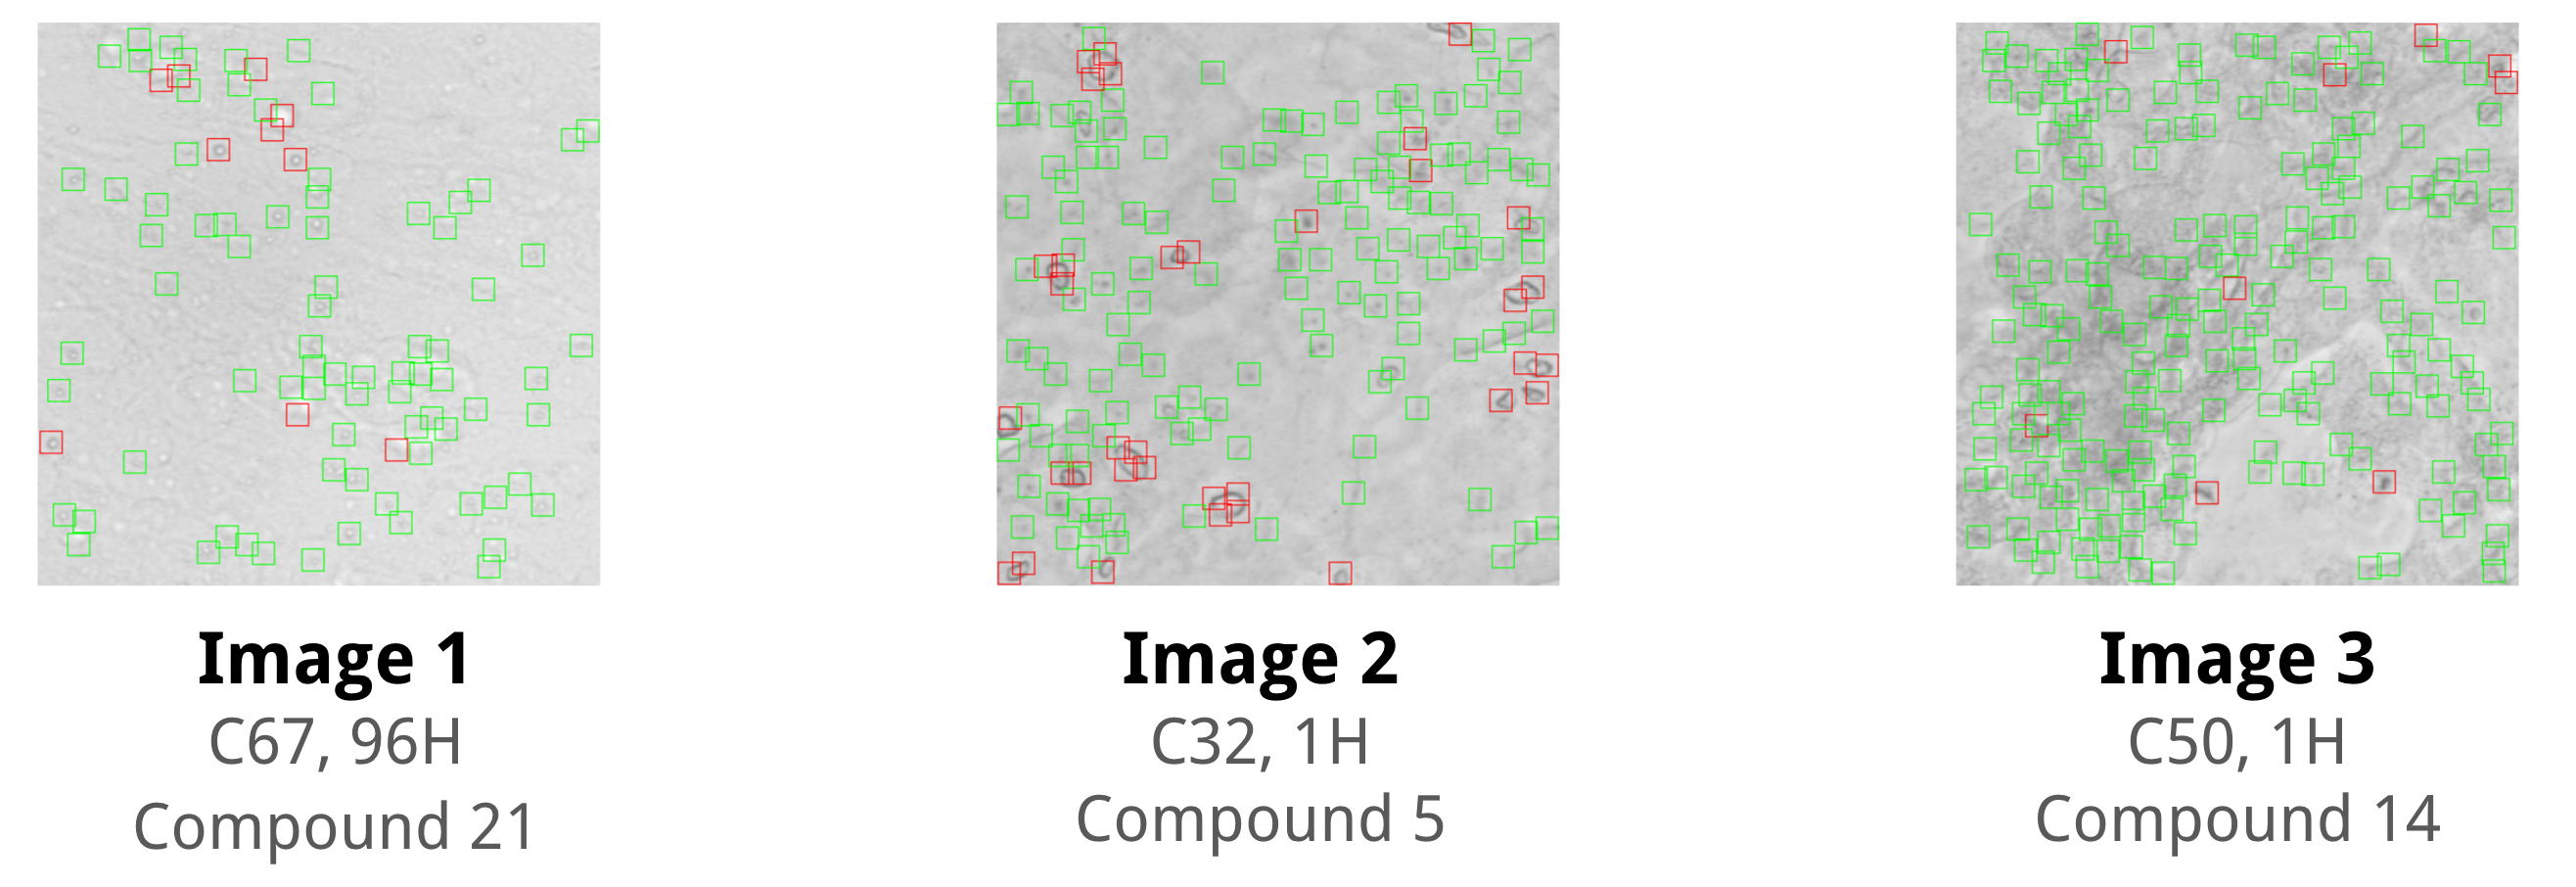

In [18]:
from IPython.display import Image
Image("training.png")

Two learning strategies with different learning parameters were evaluated. The parameters for each step for strategy A are outlined in the table below:

| Training Step                   | Parameters                                                                          |
|---------------------------------|-------------------------------------------------------------------------------------|
| Foreground-background detection | Filling holes, mean-variance feature                                                |
| Cell detection                  | Window size: 21, learning method: LDA, features: grey value texture                     |
| Classification                  | Features: eccentricity, ellipticity, haralick texture, max intensity, mean-variance |

The evaluation of strategy A is presented below:

| Well/Replicate | Time | Precision     | Recall       | F1           |
|----------------|------|---------------|--------------|--------------|
| C32/No. 8      | 1    | 1             | 0.8636363636 | 0.9268292683 |
| C32/No. 8      | 24   | 1             | 0.6341463415 | 0.776119403  |
| C32/No. 8      | 96   | 0.9857142857  | 0.7666666667 | 0.8625       |
| C50/No. 8      | 1    | 0.4444444444  | 0.6666666667 | 0.5333333333 |
| C50/No. 8      | 24   | 0.5217391304  | 0.4285714286 | 0.4705882353 |
| C50/No. 8      | 96   | 1             | 0.6833333333 | 0.8118811881 |
| C82/No. 8      | 1    | 1             | 0.3333333333 | 0.5          |
| C67/No. 8      | 1    | 0.6285714286  | 1            | 0.7719298246 |
| C67/No. 8      | 24   | 1             | 0.2          | 0.3333333333 |
| C67/No. 8      | 96   | 1             | 0.6538461538 | 0.7906976744 |
| C55/No. 5      | 1    | 0.7878787879  | 0.619047619  | 0.6933333333 |
| C55/No. 5      | 24   | 0.9615384615  | 0.5208333333 | 0.6756756757 |
| C55/No. 5      | 96   | 0.5454545455  | 0.1764705882 | 0.2666666667 |
| C79/No. 7      | 1    | 0.9230769231  | 0.4137931034 | 0.5714285714 |
| C79/No. 7      | 24   | 0.06194690265 | 1            | 0.1166666667 |
| C79/No. 7      | 96   | 0.8333333333  | 0.2380952381 | 0.3703703704 |
| Average | | 0.7933561402 | 0.5749025106 | 0.5919595965 |

The parameters used in strategy B are outlined below:

| Training Step                   | Parameters                                                                             |
|---------------------------------|----------------------------------------------------------------------------------------|
| Foreground-background detection | Filling holes, mean-variance feature                                                   |
| Cell detection                  | Window size: 25, learning method: LDA,  features: grey value texture, haralick texture |
| Classification                  | Features: ellipticity, haralick texture, histogram, mean-variance                      |

Without performing an intensive evaluation, strategy A had visibly better precision and recall.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import datetime
from collections import defaultdict
import scipy
import scipy.stats
import ntpath
import itertools as itt
import matplotlib.pyplot as plt
from numpy import array as c

plt.rcParams['figure.figsize'] = 16, 9

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Data Analysis

After training with strategy A, the entire set of images from the lipid droplet assay was evaluated. ZETA output the results of classification in a folder mirroring the folder structure of the input data. First, the individual CSV files from each of these directories are collated and annotated with information from the lipid droplet assay. The Image Path column is parsed to make annotations of the time interval, well number, and replicate number.

In [2]:
base_in  = os.path.expanduser('~/Desktop/HCA 2016 Data/assay/resultPath')
base_out = os.path.expanduser('~/Desktop/HCA 2016 Data/')

In [3]:
intervals = 'VAC3-1H96H-20x', 'VAC3-24H96H-20X', 'VAC3-96H96H-20X'

compounds = {
    'Cpd 01': list(range(14, 24)),
    'Cpd 05': list(range(26, 36)),
    'Cpd 10': list(range(38, 48)),
    'Cpd 14': list(range(50, 60)),
    'Cpd 21': list(range(62, 72)),
    'Negative': list(range(74, 84))
}

positive_compounds = sorted(compound for compound in compounds if compound != 'Negative')

valid_wells = set(itt.chain.from_iterable(compounds.values()))

calcium = {}
ca = {}

for compound, cwells in compounds.items():
    for well in cwells[0:5]:
        calcium[well] = 'low'
    for well in cwells[5:10]:
        calcium[well] = 'high'
        
    for well in cwells:
        ca[well] = compound
        
concentrations = {
    -5: [14,15,16,26,27,28,38,39,40,50,51,52,19,20,21,31,32,33,43,44,45,55,56,57],
    -6: [17,18,29,30,41,42,53,54,22,23,34,35,46,47,57,59,62,67],
    -7: [63,68],
    -8: [64,69],
    -9: [65,70],
    -10: [66,71],
    0: list(range(74, 84))
}

concentrations = {well: conc for conc, wells in concentrations.items() for well in wells}

In [4]:
results_raw = {}

for interval in intervals:
    interval_path = os.path.join(base_in, interval)
    
    if os.path.exists(os.path.join(interval_path, '.DS_Store')):
        os.remove(os.path.join(interval_path, '.DS_Store'))
    
    for well_code in os.listdir(interval_path):
        well_path = os.path.join(interval_path, well_code)
        
        if not os.path.isdir(well_path):
            continue
        
        well = int(well_code[1:])
        if well not in valid_wells:
            continue
        
        data_path = min(f for f in os.listdir(well_path) if f.endswith('.csv'))
        df = pd.read_csv(os.path.join(well_path, data_path))

        images = df['Image Path'].map(lambda path: ntpath.basename(os.path.normpath(path)))

        image_well = images.map(lambda v: int(v[1:3]))
        time = images.map(lambda v: 1 if '1H96H' in v else (24 if '24H96H' in v else 96))
        replicate = images.map(lambda v: int(v[-5:-4]))

        df['Image Path'] = images
        df['Well'] = image_well
        df['Interval'] = time
        df['Replicate'] = replicate
        df['Calcium'] = image_well.map(calcium)
        df['Concentration'] = image_well.map(concentrations)
        df['Compound'] = image_well.map(ca)

        del df['Barcode ']
        del df['Site ']
        del df['Class 2 ']
        del df['Well ']
            
        results_raw[interval, well] = df
    
results_raw = pd.concat(list(results_raw.values()))
results_raw.to_csv(os.path.join(base_out, 'results_raw.csv'))

The rows of the CSV correspond to objects identified in each image. Each row has `1` in the column corresponding to its class. The entire CSV is aggregated to count how many objects were identified as lipid droplets for each interval, well, and replicate. The well numbers are then resolved to compound name, compound concentration, and calcium concentration.

In [5]:
results_count = results_raw.groupby(['Interval', 'Well', 'Replicate'])['Class 1 '].sum().reset_index()

results_count['Concentration'] = results_count['Well'].map(concentrations)
results_count['Compound'] = results_count['Well'].map(ca)
results_count['Calcium'] = results_count['Well'].map(calcium)

results_count['Count'] = results_count['Class 1 ']
del results_count['Class 1 ']

In [6]:
# grouping order
gbc = ['Interval', 'Compound', 'Calcium', 'Concentration']

The data is further aggregated to calculate the mean and variance of the count across the replicates of each interval, compound, and calcium concentration. Here, biological replicates of the same compound concentration across multiple wells and technical replicate images are aggregated.

In [7]:
results_grouping = results_count.groupby(gbc)['Count']
results_statistics = results_grouping.mean().reset_index()

results_statistics['Mean'] = results_statistics['Count']
del results_statistics['Count']
results_statistics['Std'] = results_grouping.std().reset_index()['Count']

The raw lipid droplet counts are reported for each compound with either high or low calcium concentration and for each compound concentration.

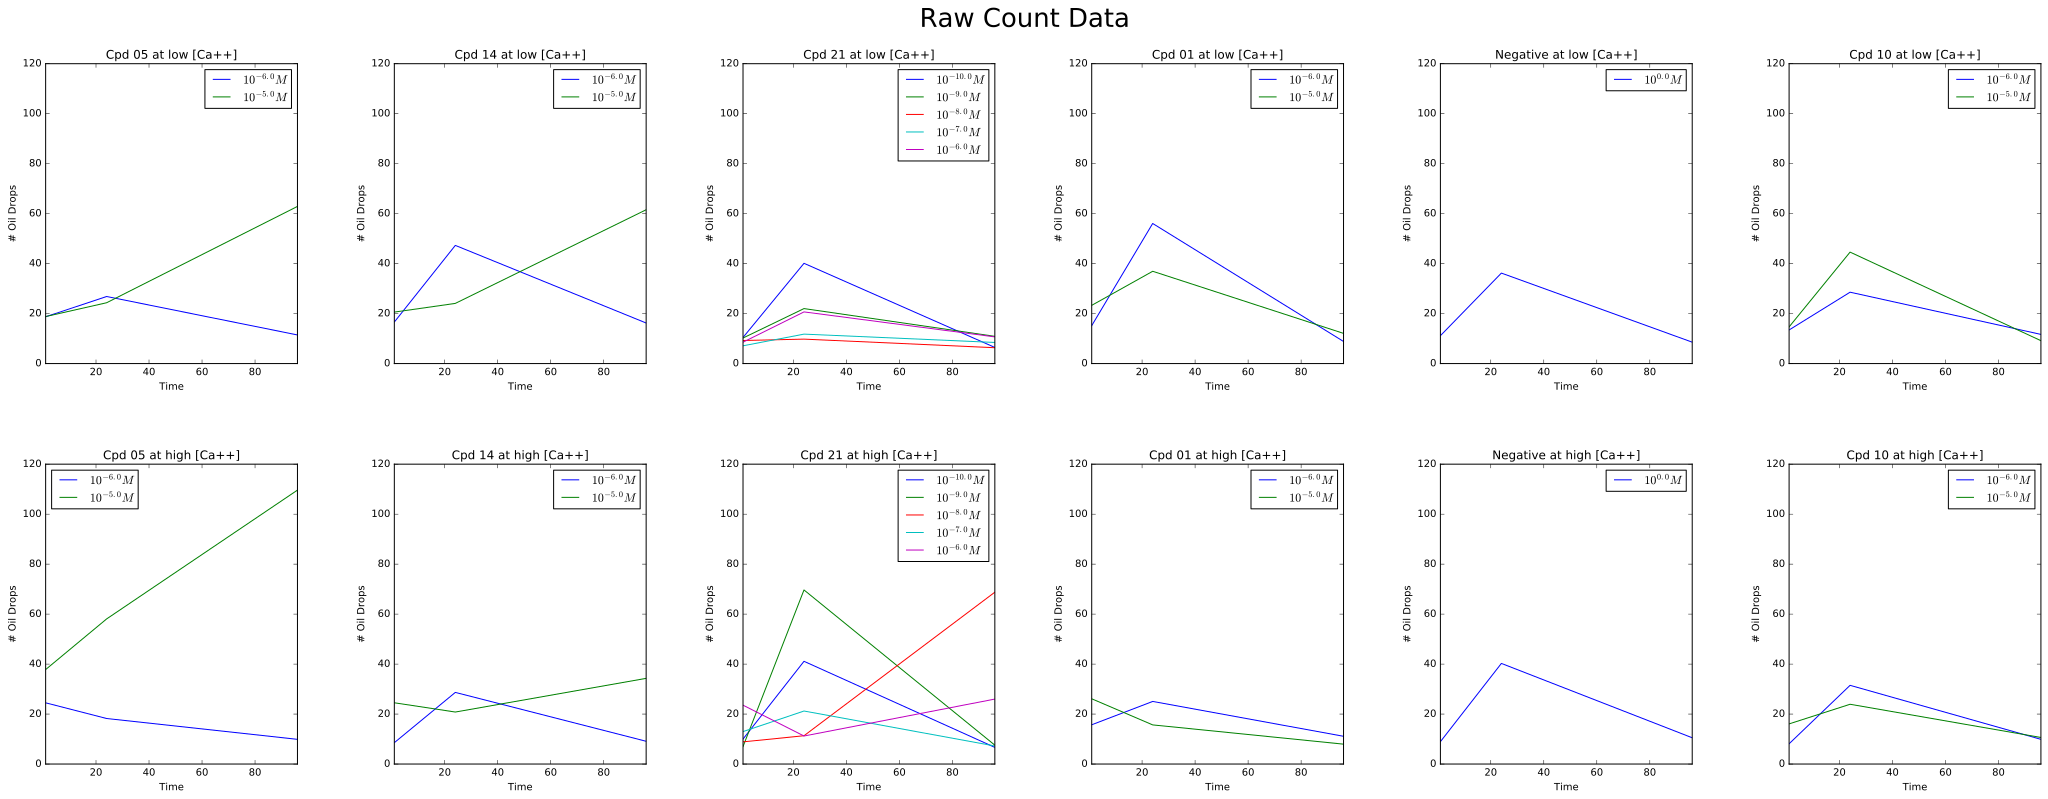

In [8]:
# see http://pandas.pydata.org/pandas-docs/stable/visualization.html#trellis-plotting-interface

fig, ax = plt.subplots(2, len(compounds), figsize=(30,12))

for i, compound in enumerate(compounds):
    a = results_statistics[results_statistics['Compound'] == compound]
    
    l = a[a['Calcium'] == 'low']
    h = a[a['Calcium'] == 'high']
    
    for concentration in sorted(set(h['Concentration'])):
        l[l['Concentration'] == concentration].plot(x='Interval', y='Mean', ax=ax[0, i], 
                                                    label="$10^{{{}}} M$".format(concentration))
        h[h['Concentration'] == concentration].plot(x='Interval', y='Mean', ax=ax[1, i], 
                                                    label="$10^{{{}}} M$".format(concentration))

    ax[0, i].set_title('{} at low [Ca++]'.format(compound))
    ax[1, i].set_title('{} at high [Ca++]'.format(compound))
    
for sax in ax.ravel():
    sax.set_ylabel('# Oil Drops')
    sax.set_xlabel('Time')
    sax.set_ylim([0, 120])

plt.suptitle('Raw Count Data', fontsize=26)
plt.tight_layout(pad=6.0)
plt.show()

These graphs are difficult to interpret without contextualizing the counts agains the appropriate negative results. First, the counts for each compound are analyzed for statistical significance with Z-factor analysis and Welch's T-Test. They quantify the seperation between the response to the compound and the negative control.

In [9]:
positive_test    = results_count[results_count['Compound'] != 'Negative']
negative_control = results_count[results_count['Compound'] == 'Negative']
t_test_results = []

for (i_interval, i_compound, i_calcium, i_concentration), i_df in positive_test.groupby(gbc):
    
    interval_slice = negative_control['Interval'] == i_interval
    calcium_slice  = negative_control['Calcium'] == i_calcium
    
    negative_counts = negative_control[c(interval_slice) & c(calcium_slice)]['Count']
    negative_mean = np.mean(negative_counts)
    negative_std = np.std(negative_counts)
      
    positive_counts = i_df['Count']
    positive_mean = np.mean(positive_counts)
    positive_std = np.std(positive_counts)
 
    welch_result = scipy.stats.ttest_ind(negative_counts, positive_counts, equal_var=False)
    z_factor = 1 - 3 * (positive_std + negative_std) / np.abs(positive_mean - negative_mean)
    
    mean_adjusted = positive_mean - negative_mean
    ratio_adjusted = np.log(positive_mean / negative_mean)
    
    t_test_results.append((i_interval, i_compound, i_calcium, i_concentration, z_factor, welch_result.pvalue, mean_adjusted, ratio_adjusted))    

t_test_results = pd.DataFrame(t_test_results, columns=gbc + ['Z_Factor', 'p', 'MeanAdjCount', 'RatioAdjCount'])

In [10]:
# from http://stackoverflow.com/a/33532498/5775947
def p_adjust_bh(p):
    """Benjamini-Hochberg p-value correction for multiple hypothesis testing."""
    p = np.asfarray(p)
    by_descend = p.argsort()[::-1]
    by_orig = by_descend.argsort()
    steps = float(len(p)) / np.arange(len(p), 0, -1)
    q = np.minimum(1, np.minimum.accumulate(steps * p[by_descend]))
    return q[by_orig]

t_test_results['mlp.adj'] = -np.log(p_adjust_bh(t_test_results['p']))

In [11]:
results = pd.merge(results_statistics, t_test_results, on=gbc, how='left')
results.to_csv(os.path.join(base_out, 'results.csv'))

In [12]:
def show(col, ylim=(-120,150), title="", ylab=''):
    fig, ax = plt.subplots(2, len(positive_compounds), figsize=(30, 12))
    for i, compound in enumerate(positive_compounds):
        a = results[results['Compound'] == compound]
       
        l = a[a['Calcium'] == 'low']
        h = a[a['Calcium'] == 'high']
    
        for concentration in sorted(set(h['Concentration'])):
            l[l['Concentration'] == concentration].plot(x='Interval', y=col, 
                                                        ax=ax[0, i], label="10^{{{}}} M".format(concentration))
            h[h['Concentration'] == concentration].plot(x='Interval', y=col, 
                                                        ax=ax[1, i], label="10^{{{}}} M".format(concentration))
    
        ax[0, i].set_title('Compound {} at low [Ca++]'.format(compound))
        ax[1, i].set_title('Compound {} at high [Ca++]'.format(compound))
    
    for s_ax in ax.ravel():
        s_ax.set_ylabel(ylab)
        s_ax.set_xlabel('Time')
        s_ax.set_ylim(ylim)
        s_ax.axhline(0, linestyle='--', color='grey', linewidth=1)    
    
    plt.suptitle(title, fontsize=26)
    plt.tight_layout(pad=6.0)
    plt.savefig(os.path.join(base_out, '{}.png'.format(col)))
    plt.show()

Values closer to 1 in Z-factor analysis show significant seperation between a perterbagen and the negative control, while negative values show poor seperation. With a small number of replicates and high amount of technical and biological noise, it was difficult to obtain good Z-values. However, compounds 5 and 14 at low calcium concentration showed consitiently better results than the other compounds.

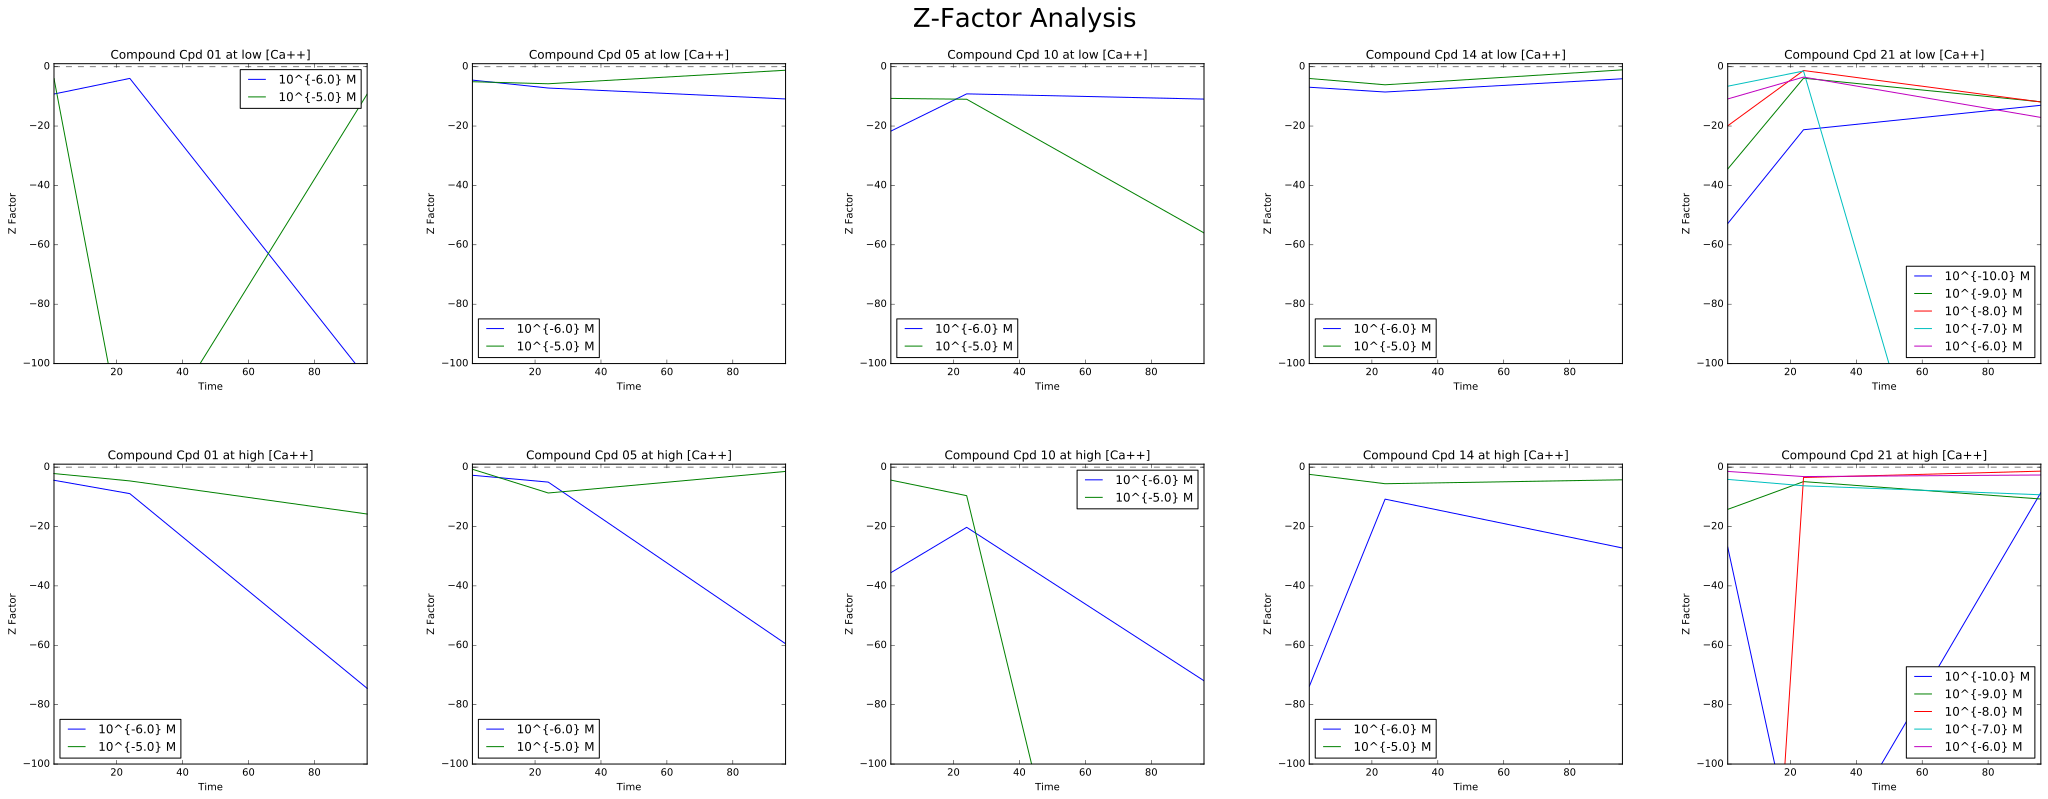

In [13]:
show('Z_Factor', ylim=(-100, 1), title="Z-Factor Analysis", ylab='Z Factor')

The p-values from Welch's T-test are corrected for multiple hypothesis testing using the Benjamini-Hochberg method. They are presented on a negative log scale so significance is monotonically increasing. The statistical analysis also shows the best separation for compounds 5 and 14 at 96 hours, and for Compound 21 at 24 hours. However, the effect on compound 21 was not monotonic with the increasing concentration, and might be noise.

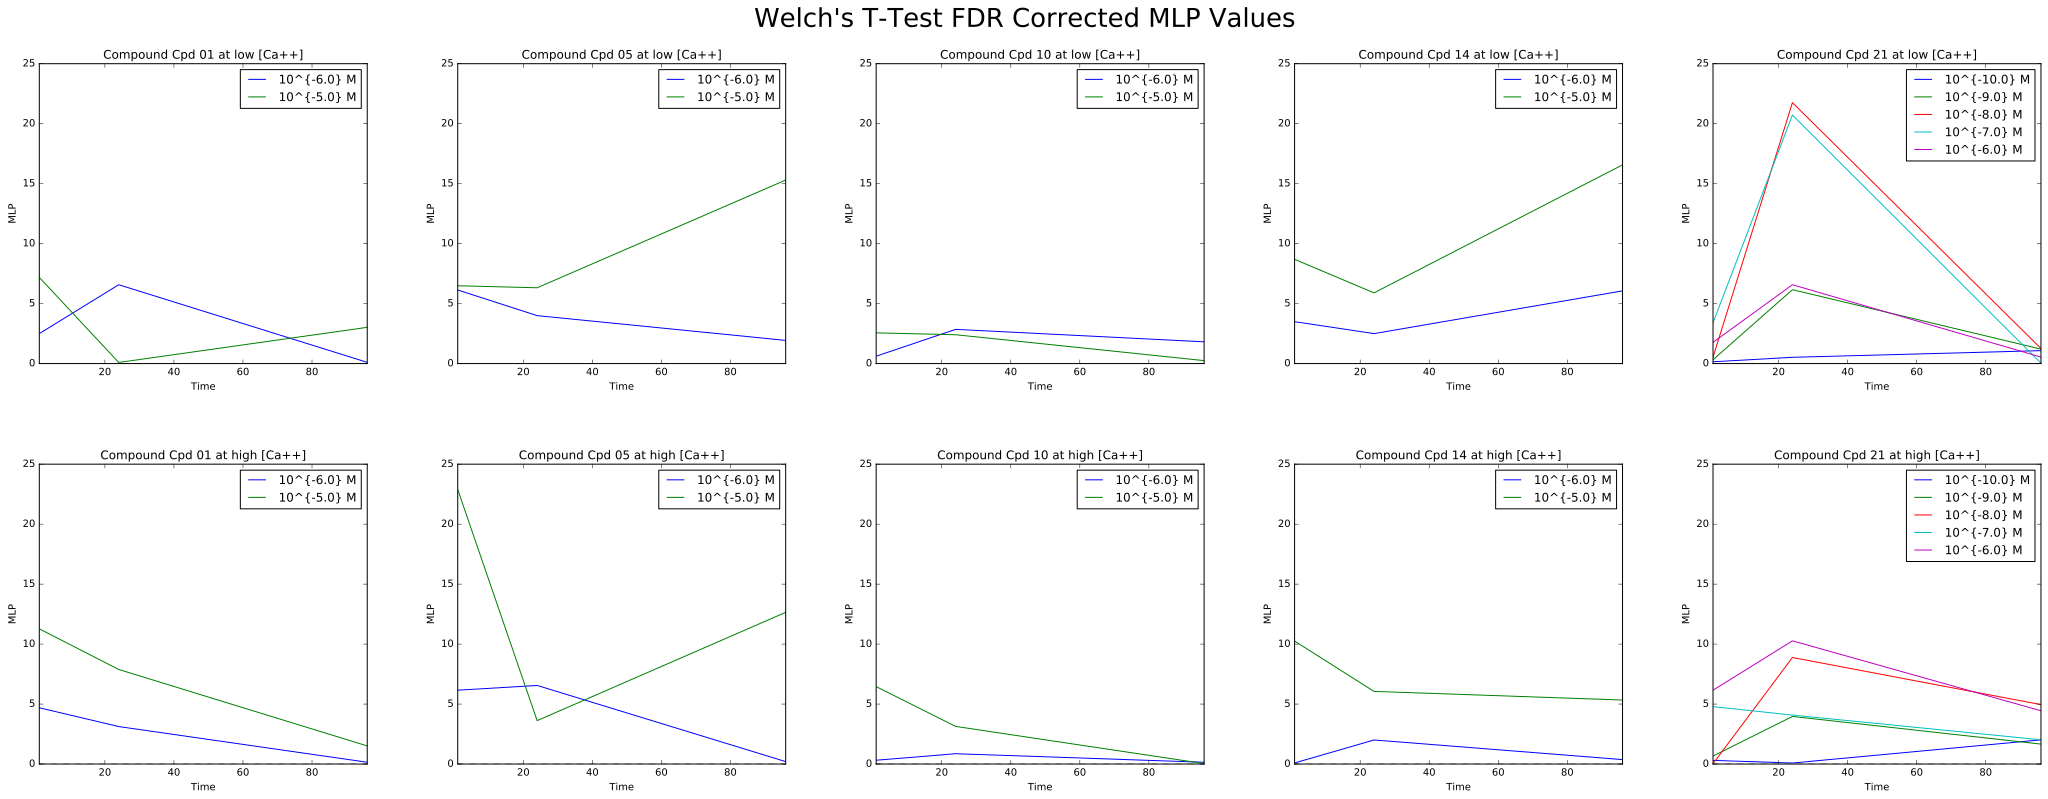

In [14]:
show('mlp.adj', ylim=(0, 25), title="Welch's T-Test FDR Corrected MLP Values", ylab='MLP')

Finally, two methods are used to correct the raw lipid droplet counts against the negative conrols. In the first normalization scheme, the effect of the negative control is subtracted. This correction showed that compounds 5 and 14 had the largest effects at 96 hours, and that most compounds were ineffective at 1 and 24 hours.

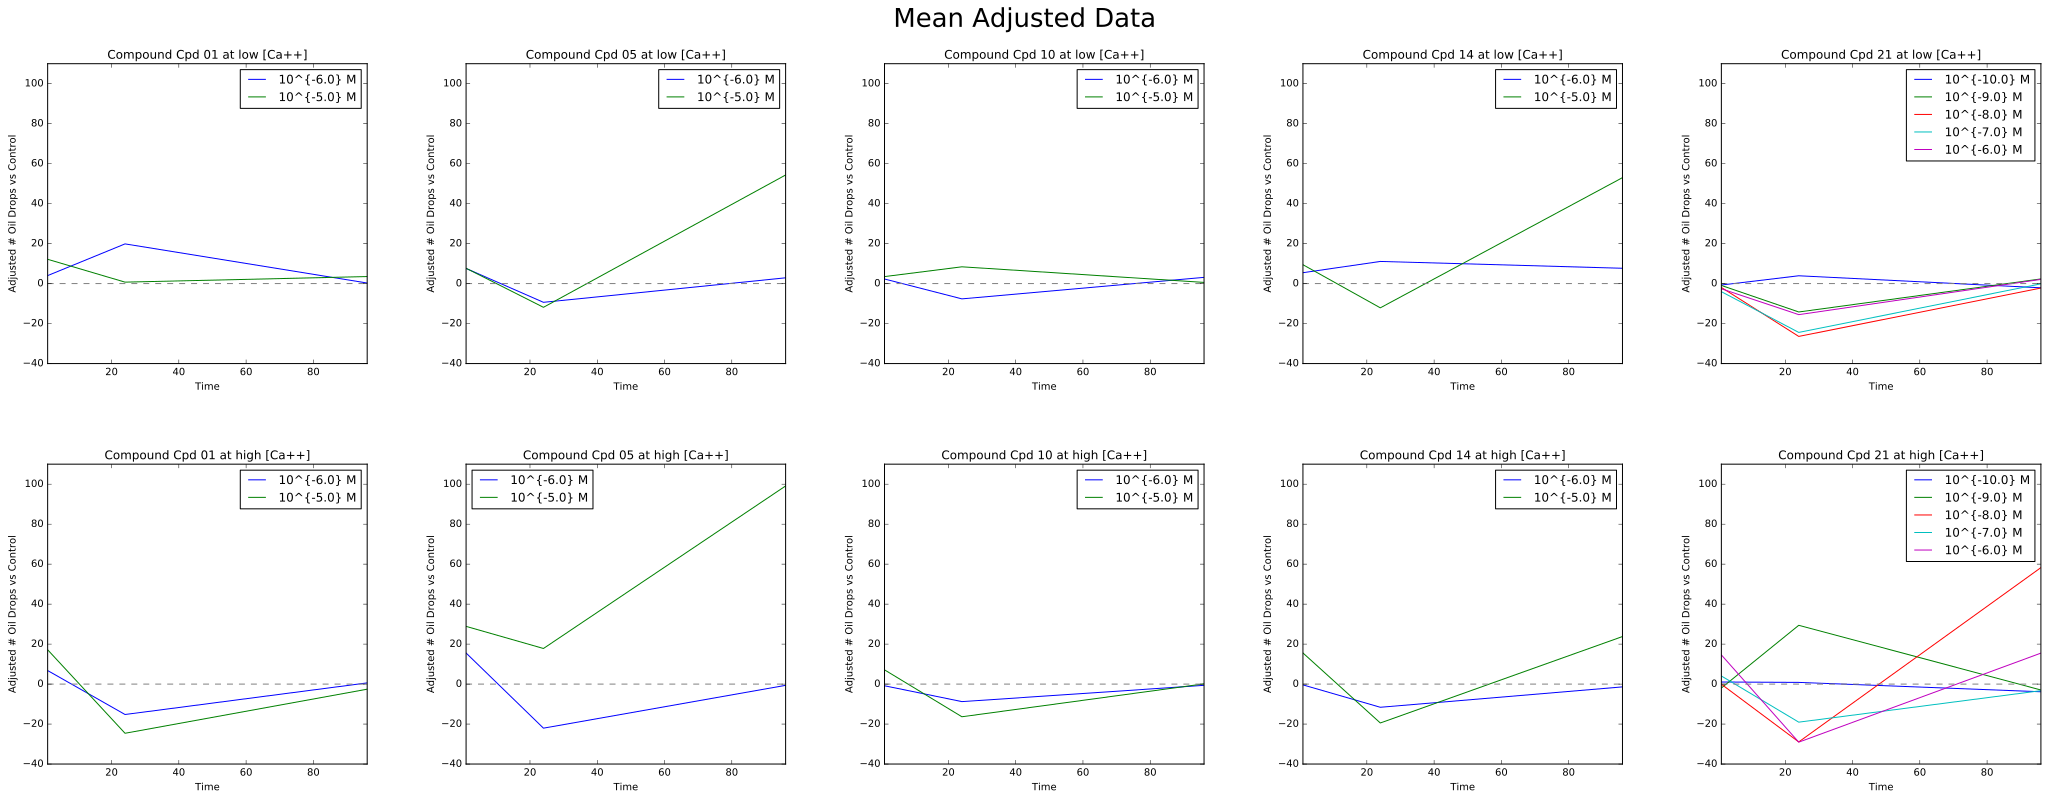

In [15]:
show('MeanAdjCount', ylim=(-40, 110), title="Mean Adjusted Data", ylab='Adjusted # Oil Drops vs Control')

The second correction is to take the log ratio of each compound's effect to the negative control's effect. This normalization makes comparison between different time intervals possible and eases interpretation. Positive log ratios correspond to increased lipid droplet formation due to the compound while negative log ratios correspond to decreased droplet formation. This normalization also show that compounds 5 and 14 have the greatest desired effect of increasing lipid droplet formation.

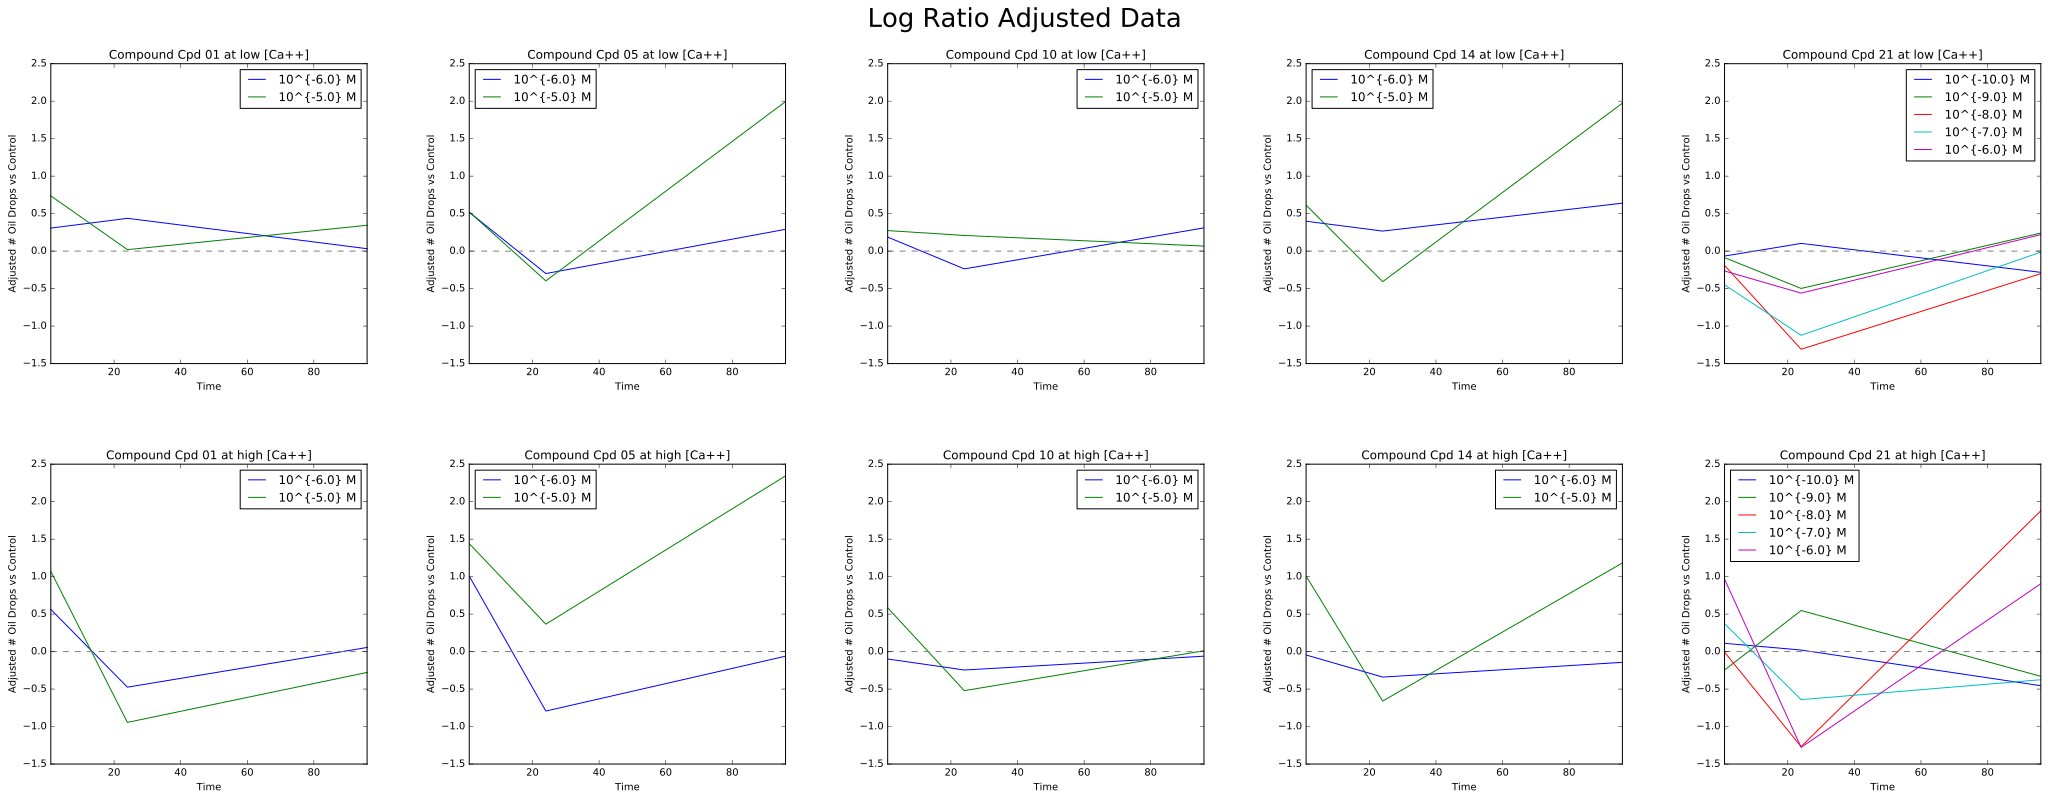

In [16]:
show('RatioAdjCount', ylim=(-1.5, 2.5), title='Log Ratio Adjusted Data', ylab='Adjusted # Oil Drops vs Control')

# Discussion and Conclusion

The effects of each compound were systematically lower at 24 hours. This assay was an endpoint assay, and investigation of the images showed that there was much more noise in the plates at 24 hours. This caused the negative controls to have a much higher lipid droplet count, and each compound to have much smaller relative effects. This can be seen in the example images below:

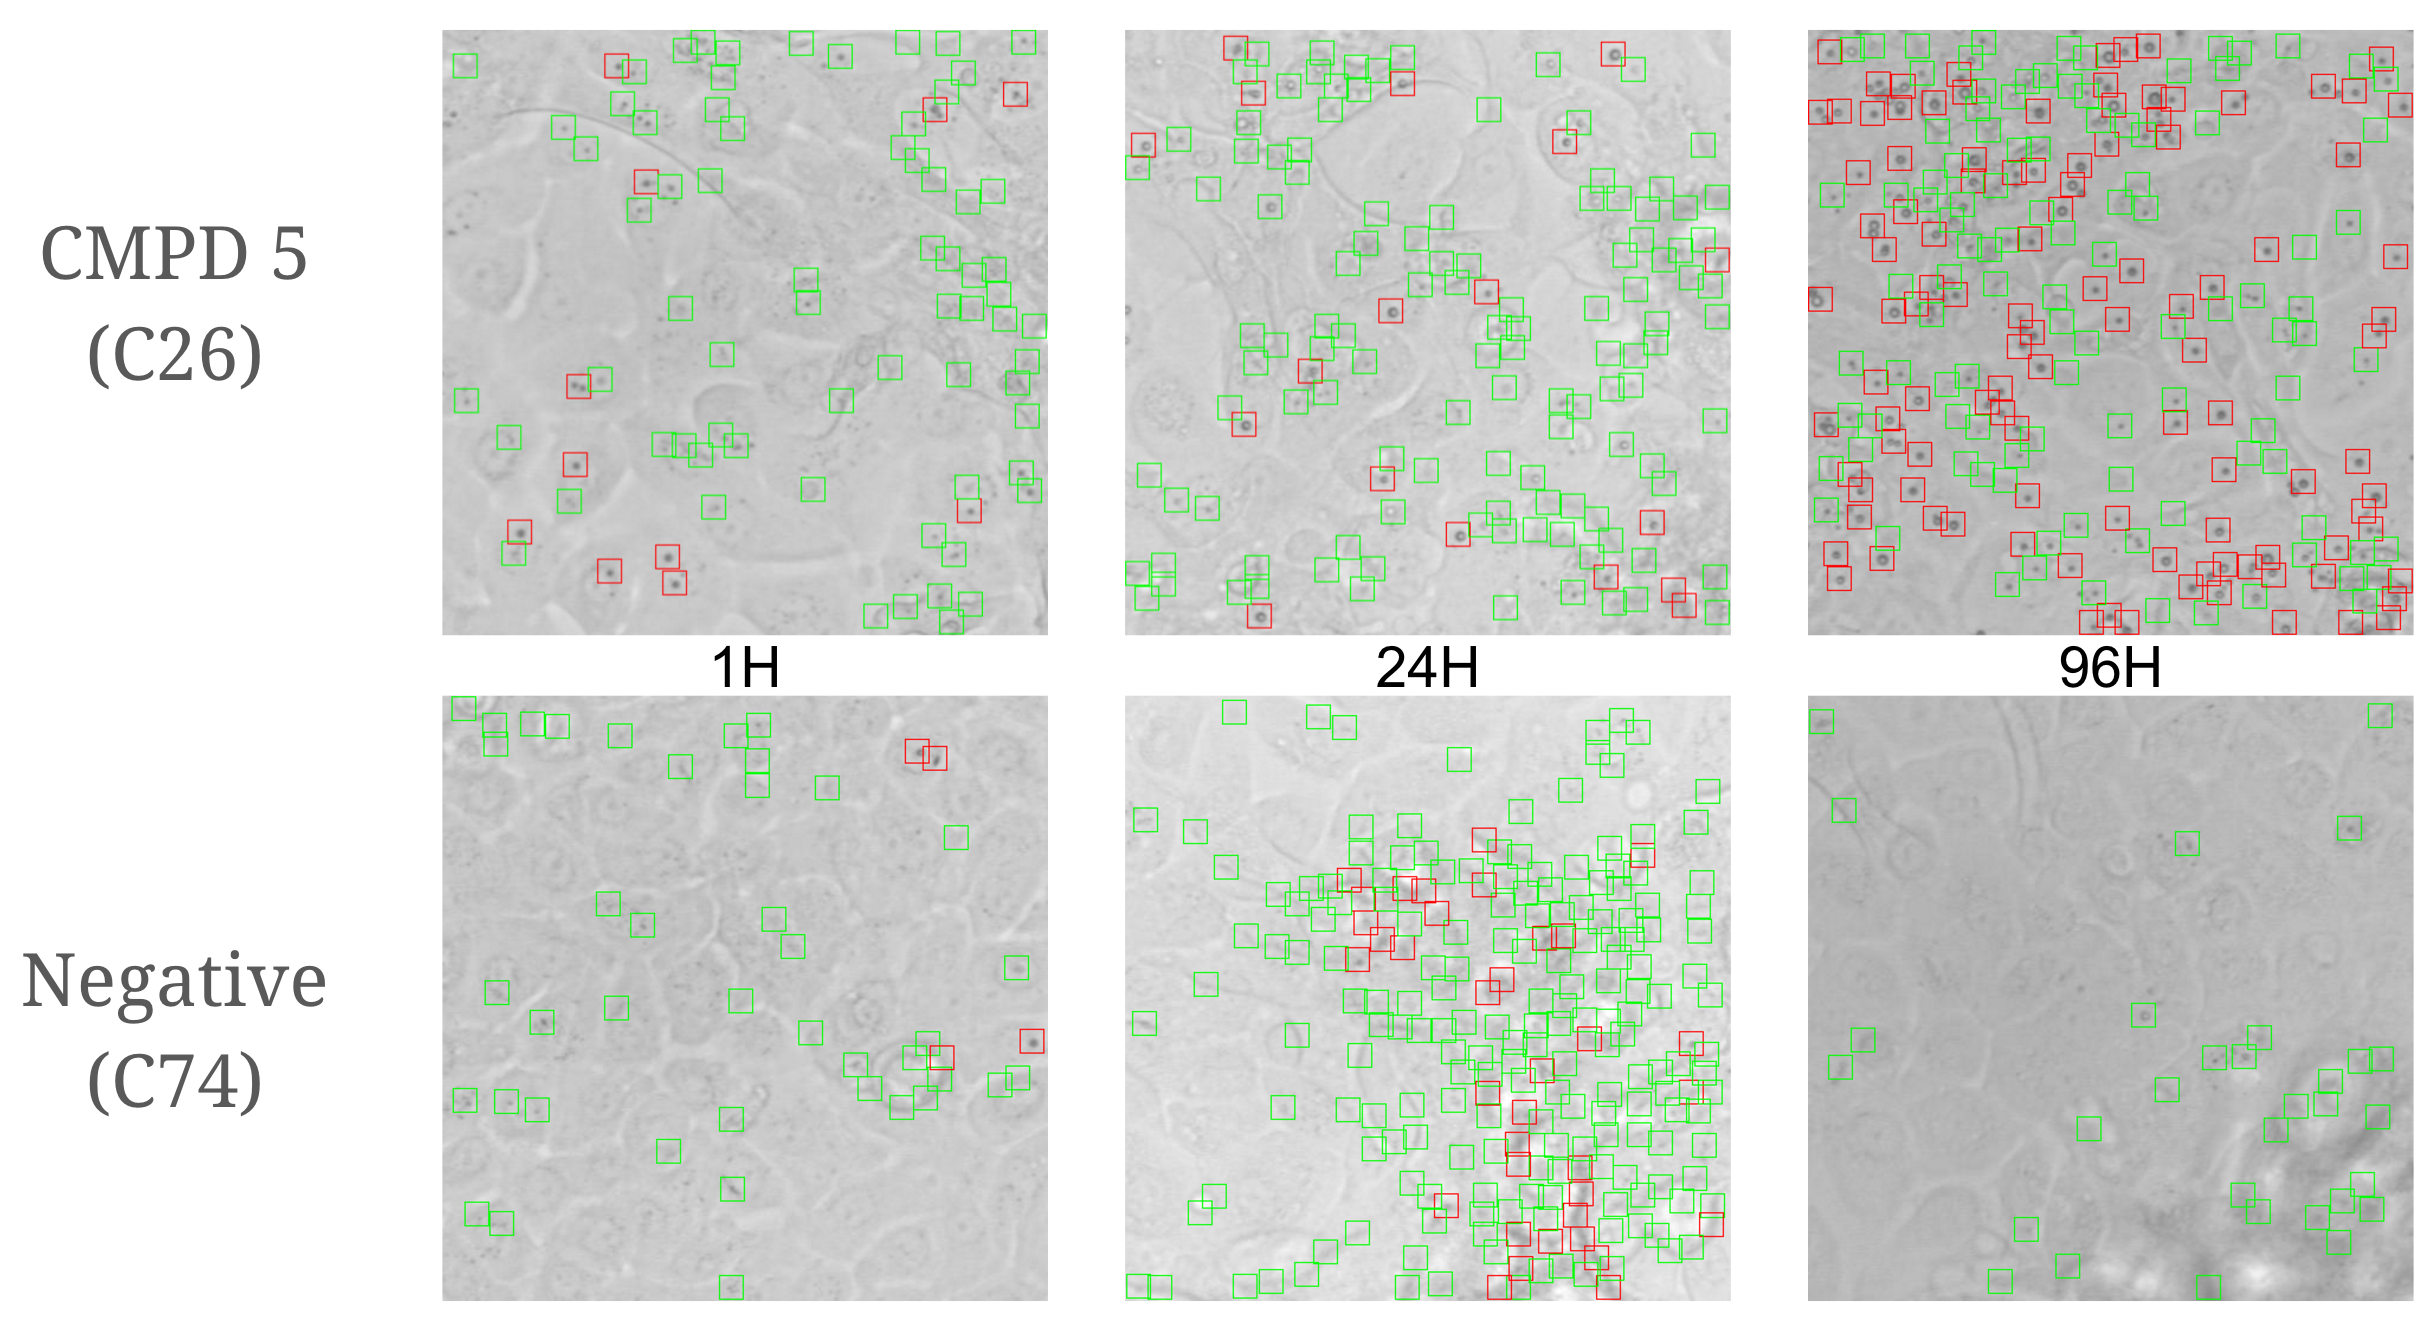

In [19]:
Image('anomaly.png')

There could be many more contributing factors to why the active compounds only seemed active at 96 hours. One example might be that the compounds act through a slow mechanism, or are taken in very slowly to the cells. Ultimately, compounds 1 and 10 show neither statistical nor visual effects. Compound 21 shows some visual effect, but is not statistically significant and might be a product of noise. Finally, Compounds 5 and 14 have the highest effect. These effects are pronounced easily with the following comparison between the negative control, an inactive compound, and an active compound. The effect of noise is also clear.

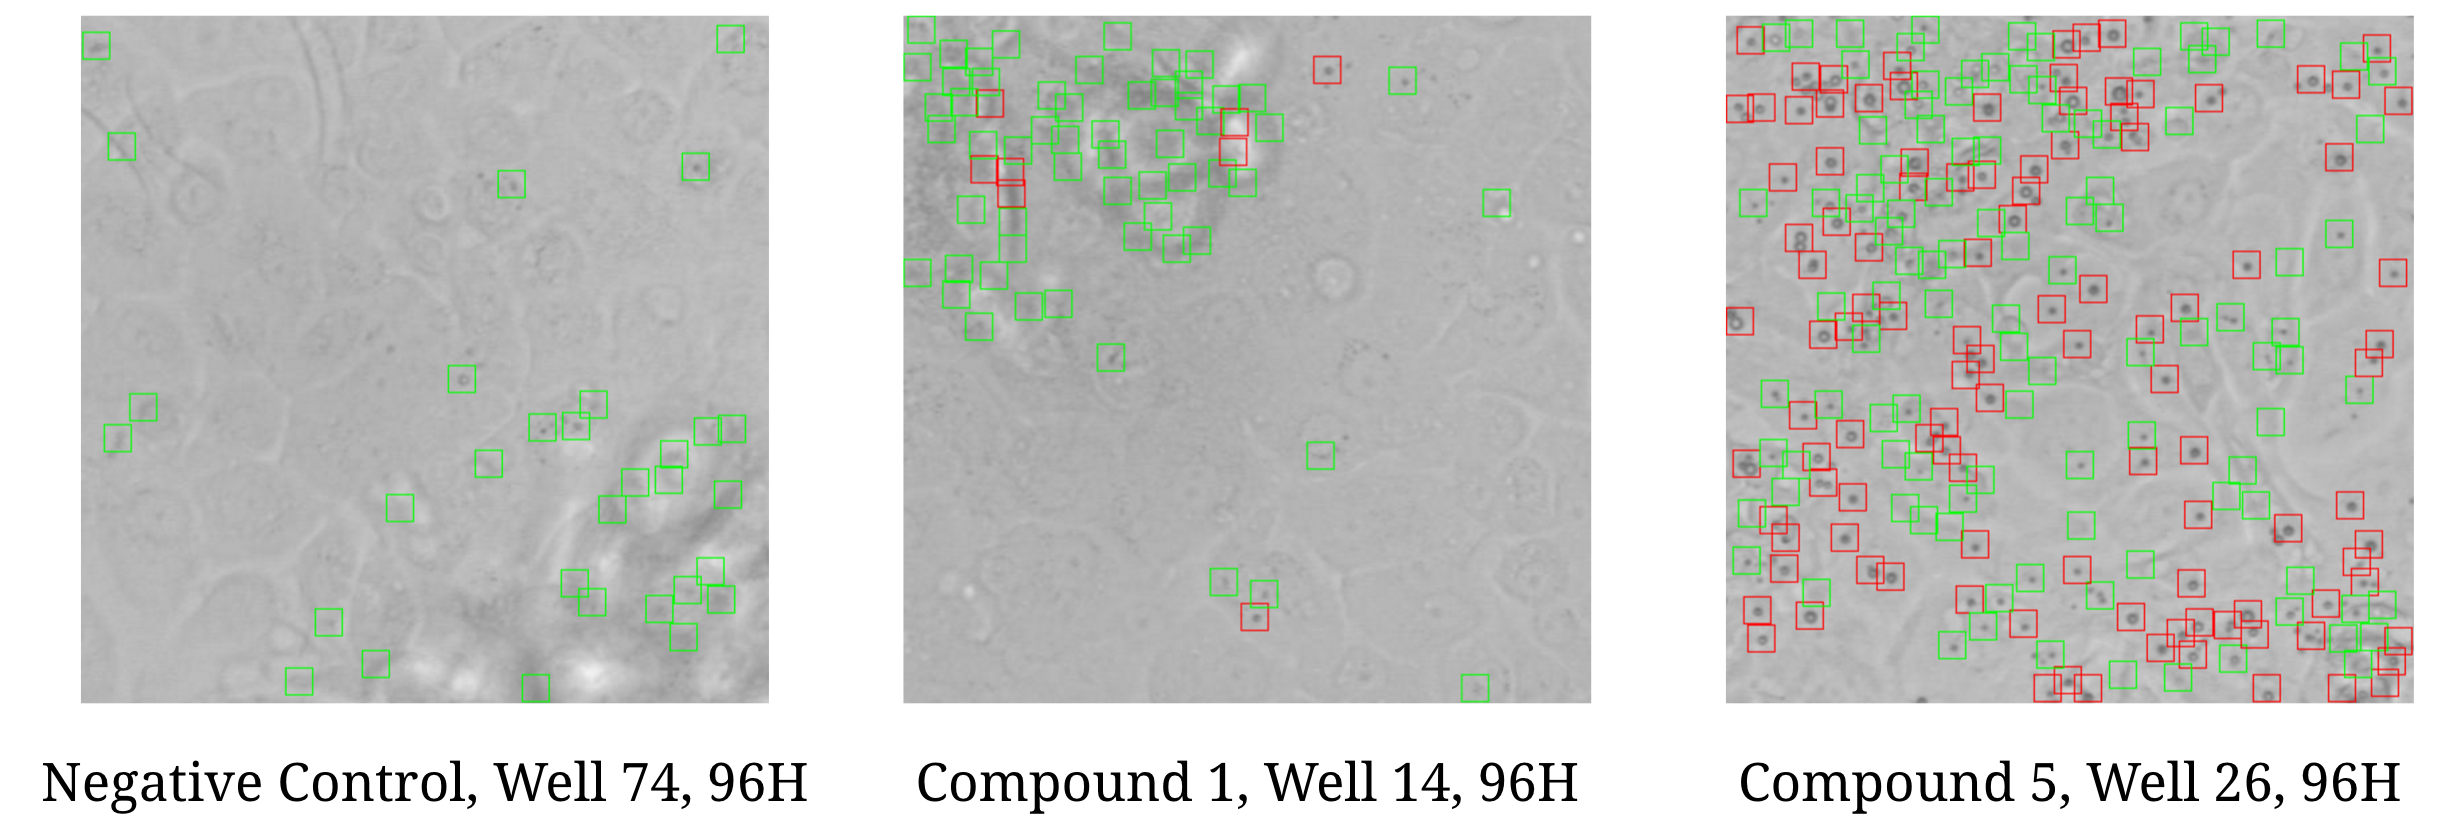

In [20]:
Image('conclusion.png')